# Calculate SPI

In [5]:
import matplotlib.pyplot as plt
import xarray as xr
import tempfile
import dask
from dask.diagnostics import ProgressBar

import os
import numpy as np
from glob import glob
import warnings
from numpy import apply_along_axis
from scipy.stats import rankdata
import pandas as pd
import lib_david

from dask.distributed import Client

# Dask settings
dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, # This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

nmonths   = 3

enc = {"SPI{}".format(nmonths): {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

In [2]:
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "32000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 298.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44213,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 298.02 GiB
Comm: tcp://127.0.0.1:42565,Total threads: 1
Dashboard: /proxy/36185/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:35823,


In [3]:
# #< Functions

# def getSizeGB(arr):
#     return '{:.3f} GB'.format(arr.nbytes / 1024 ** 3)

def rank_by_month(da):
    """
    Return the ranking of each grid point in 'da', calculated by grouping each
    horizontal grid cell by month and returning the ranking within that
    group at each time point (developed by Scott Wales)
    """

    # Drop time chunking
    rechunked = da.chunk({'time': None})

    # Check size of one chunk
    chunksize = np.prod(da.data.chunksize)*da.data.itemsize
    if chunksize > 256 * 1024**2:
        warnings.warn("Chunk size is over 256 mb, try smaller horizontal chunks")

    # Each chunk contains the full timeseries for a specific horizontal domain
    # Use xarray.map_blocks to analyse that domain

    month = da.time.dt.month
    # da.coords['month'] = month

    # def rank_along_axis(array, axis):
    #     return apply_along_axis(rankdata, axis, array, method='dense')

    # return da.groupby('time.month').reduce(rank_along_axis, dim='time')  # New line to circumvent block_ranker which crashes but doesn't work

    def rank_along_axis(x, **kwargs):
        return apply_along_axis(rankdata, 0, x, **kwargs)
    def block_ranker(block):
        if block.size == 0:
            return block

        return block.groupby('time.month').apply(rank_along_axis, method='dense')

    return da.map_blocks(block_ranker)

def SPI(arr, ndays):
    """
    For a specified date and nday length, calculates the standardised precipitation
    index (SPI, McKee 1993), based on daily precipitation data.

    Months are defined as 30-day intervals. Leap years are simply kicked out to
    simplify the ranking of the data.

    Framework based on Farahmand and AghaKouchak 2015

    Original code based on EDDI Fortan code from: Mike Hobbins
    Date: March 10, 2016

    Rewritten in Python by: David Hoffmann
    Date: November 21, 2018

    New rank_by_monthday by: Scott Wales

    Rewritten for dask by: Christian Stassen
    Date: June, 2020

    :param arr: xarray dataset
    :param nmonths: scaling parameter e.g. avaraging over 12 months -> SPI12

    """

    print('Calculating rolling sum...')
    with xr.set_options(keep_attrs=True):
        # arr = arr.rolling(time=nmonths, center=False).sum().dropna(dim='time',how='any')
        arr = da.rolling(time=nmonths, center=False).sum(skipna=False).dropna(dim='time',how='any')
    
    arr # = arr.chunk({'time':None, 'lat':15, 'lon':15})


    print('Ranking by month of year...')
    rank = rank_by_month(arr)
    # rank = rank.drop('month') # drop monthday dimension
    rank

    # Define sample size wrt length of climatology + year in question
    N = len(np.unique(arr.time.dt.year))+1 # climend - climstart + 1
    print(N)
    den = N+0.33
    
    # Empirical Tukey plotting position (Wilks 2011)
    print('Calculating P...')
    P = (rank - 0.33)/den
    
    
    print('Calculating W...')
    W1 = P.where(P > 0.5, np.sqrt(-2. * (np.log(P)))) # Contains the value we want where P<=0.5, else contains P
    # W1 = P.where(P>0.5,xr.ufuncs.sqrt(-2. * xr.ufuncs.log(P)))  # ufuncs not supported anymore. Kept for reference.
    W  = W1.where(P <= 0.5, np.sqrt(-2. * (np.log(1-P)))) # We take W1 values where P<=0.5, else the alternate calculation.
    # W  = W1.where(P<=0.5,xr.ufuncs.sqrt(-2. * xr.ufuncs.log(1-P))) # ufuncs not supported anymore. Kept for reference.
    
    
    # Inverse normal approximation (Vincente-Serrano et al 2010)
    print('Calculating inverse normal approximation...')
    # normalisation parameters
    C0        = 2.515517
    C1        = 0.802853
    C2        = 0.010328
    d1        = 1.432788
    d2        = 0.189269
    d3        = 0.001308
    pr_est1 = P.where(P>0.5, -1. * (W - (C0 + C1 * W + C2 * W**2.) / (1. + d1 * W + d2 * W**2. + d3 * W**3.)))
    pr_est  = pr_est1.where(P<=0.5, W - (C0 + C1 * W + C2 * W**2.) / (1. + d1 * W + d2 * W**2. + d3 * W**3.))
    
    pr_est = pr_est.rename('SPI{}'.format(nmonths))

    return pr_est

In [13]:



#GWL time periods from https://github.com/IPCC-WG1/Atlas/blob/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv -> [n-9, n+10]
climatology = {'recent':{'start':1991,'end':2020},
               'current':{'start':2011,'end':2030},
               'GWL2-ssp370':{
                   # 'CMCC-ESM2':{'start':-9,'end':+10},
                   'ACCESS_ESM1.5':{'start':2048-9,'end':2048+10},
                   'ACCESS_CM2':{'start':2039-9,'end':2039+10},
                   'EC-Earth3':{'start':2038-9,'end':2038+10},
                   # 'MPI-ESM1-2-HR':{'start':2050-9,'end':2050+10},
                   # 'NCAR-CESM2':{'start':-9,'end':+10},
                   'NorESM2-MM':{'start':2062-9,'end':2062+10}} # add more downscaled models
              }
    
source_char = {
    'ERA5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[]},
    'AGCD':{'var_p':'precip','var_pet':'e0','var_lat':'latitude','var_lon':'longitude','files':[]},
    'CMIP6':{
        'CMCC-ESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CMCC-ESM2','variant-id':'r1i1p1f1','version':'v1-r1'}, 
        'ACCESS-ESM1-5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-ESM1-5','variant-id':'r6i1p1f1','version':'v1-r1'},
        'ACCESS-CM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-CM2','variant-id':'r4i1p1f1','version':'v1-r1'},
        'EC-Earth3':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'EC-Earth3','variant-id':'r1i1p1f1','version':'v1-r1'},
        'MPI-ESM1-2-HR':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'MPI-ESM1-2-HR','variant-id':'r1i1p1f1','version':'v1-r1'}, # only historical},
        'NCAR-CESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CESM2','variant-id':'r11i1p1f1','version':'v1-r1'}, 
        'NorESM2-MM':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'NorESM2-MM','variant-id':'r1i1p1f1','version':'v1-r1'}
        }
    }

In [14]:
## directories
odir      = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/"

#< collecting all files
for source in source_char:
    print('Getting files for {}'.format(source))
    
    if source == 'CMIP6':
        for model in source_char[source]:
            source_char[source][model]['files'] = lib_david.get_files(source,source_char,model)
 
    else:
        source_char[source]['files'] = lib_david.get_files(source,source_char)


Getting files for ERA5
Getting files for AGCD
Getting files for CMIP6
CMCC-ESM2
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
ACCESS-ESM1-5
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
ACCESS-CM2
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
EC-Earth3
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/EC-Earth3/ssp370/r1i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
MPI-ESM1-2-HR
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/MPI-ESM1-2-HR/ssp370/r1i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
NCAR-CESM2
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CESM2/ssp370/r11i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/
NorESM2-MM
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/NorESM2-MM/ssp370/r1i1p1f1/BARPA-R/v1-r1/mon/pr/v20231001/


In [15]:
in_files = source_char['CMIP6']['EC-Earth3']['files']['p_files']
# in_files = source_char['AGCD']['files']['p_files']

In [16]:
source = 'CMIP6' #'AGCD'

In [17]:
ofile = odir+'SPI{}_{}_{}-{}.nc'.format(nmonths,source,'{}','{}') #Keep two dummys empty for now

In [18]:
#< read data
ds_in  = xr.open_mfdataset(sorted(in_files),combine='nested', concat_dim='time')#.sel(lat=slice(-40,-30),
                                                                                  #lon=slice(140,150))
if source == 'AGCD':
    da = da.sortby(da.lat)
    da = ds_in.chunk(dict(time="auto"))['precip']

if source == 'ERA5' or source == 'CMIP6':
    da=ds_in.chunk(dict(time="auto"))['pr']*86400 # convert kg m-2 s-1 to mm/day

da = da.sel(time=slice('1991','2020'))
da

<xarray.DataArray 'pr' (time: 360, lat: 436, lon: 777)> Size: 976MB
dask.array<getitem, shape=(360, 436, 777), dtype=float64, chunksize=(348, 221, 395), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1991-01-16T12:00:00 ... 2020-12-16T12:...
  * lat      (lat) float64 3kB -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9

In [19]:
#< Calculate SPI
spi = SPI(da, nmonths)
print(spi)
climstart = str(da.time.dt.year[0].data) #climatology['recent']['start']
climend = str(da.time.dt.year[-1].data) #climatology['recent']['end']

#< Save output
saver = spi.to_netcdf(ofile.format(climstart,climend), compute=False, encoding=enc)
future = client.persist(saver)
dask.distributed.progress(future)
future.compute()

Calculating rolling sum...
Ranking by month of year...
31
Calculating P...
Calculating W...
Calculating inverse normal approximation...
<xarray.DataArray 'SPI3' (time: 358, lat: 436, lon: 777)> Size: 970MB
dask.array<where, shape=(358, 436, 777), dtype=float64, chunksize=(346, 221, 395), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * lat      (lat) float64 3kB -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * time     (time) datetime64[ns] 3kB 1991-03-16T12:00:00 ... 2020-12-16T12:...


# TEST PLOT

In [20]:
climstart = '1991'
climend = '2020'
spi_ds = xr.open_dataset(ofile.format(climstart,climend))
spi_ds

<xarray.Dataset> Size: 970MB
Dimensions:  (lon: 777, lat: 436, time: 358)
Coordinates:
  * lon      (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * lat      (lat) float64 3kB -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * time     (time) datetime64[ns] 3kB 1991-03-16T12:00:00 ... 2020-12-16T12:...
Data variables:
    SPI3     (time, lat, lon) float64 970MB ...

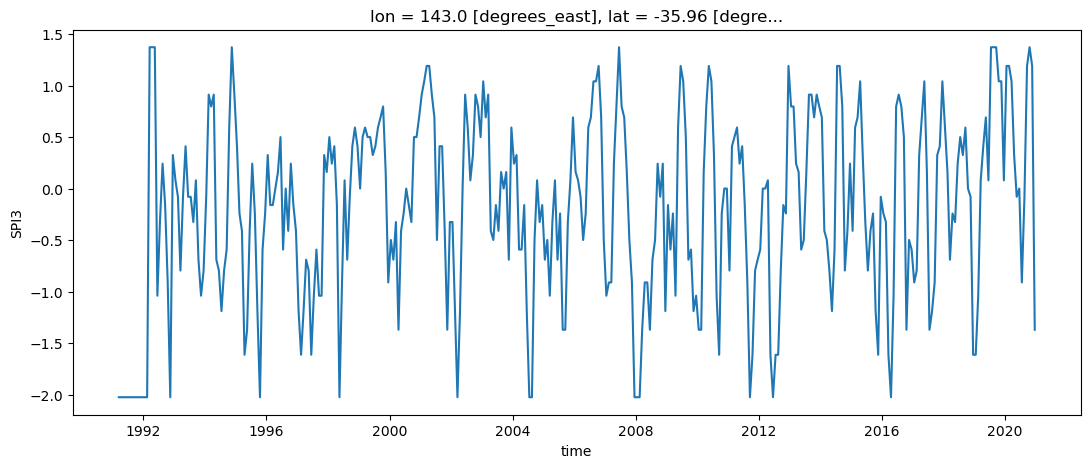

In [21]:
spi_ts = spi_ds["SPI3"].sel(lat=-36,lon=143,method='nearest')#mean(['lat','lon'])
spi_ts.plot(figsize=(13,5))

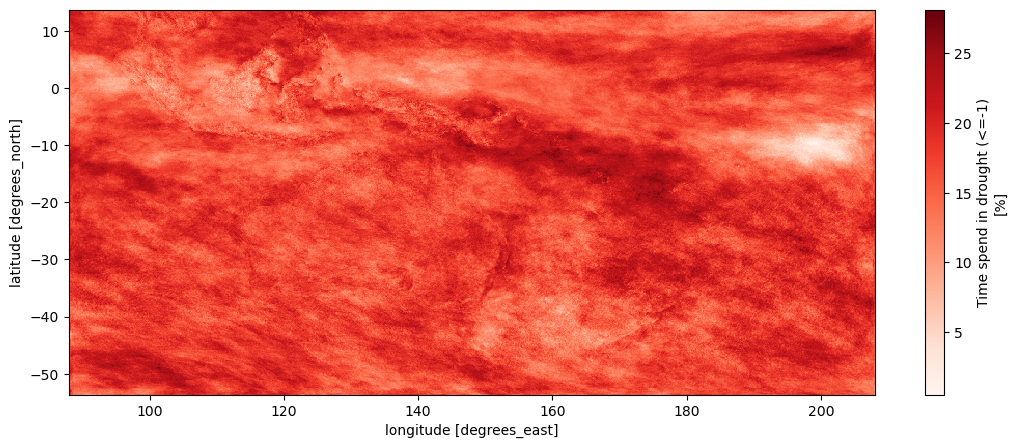

In [22]:
spi_recent = spi_ds["SPI3"].sel(time=slice('2005','2020'))
spi_tsid = ((spi_recent <= -1).sum(dim='time')/len(spi_recent.time)*100).rename("Time spend in drought (<=-1) [%]")
spi_tsid.plot(figsize=(13,5),cmap='Reds')

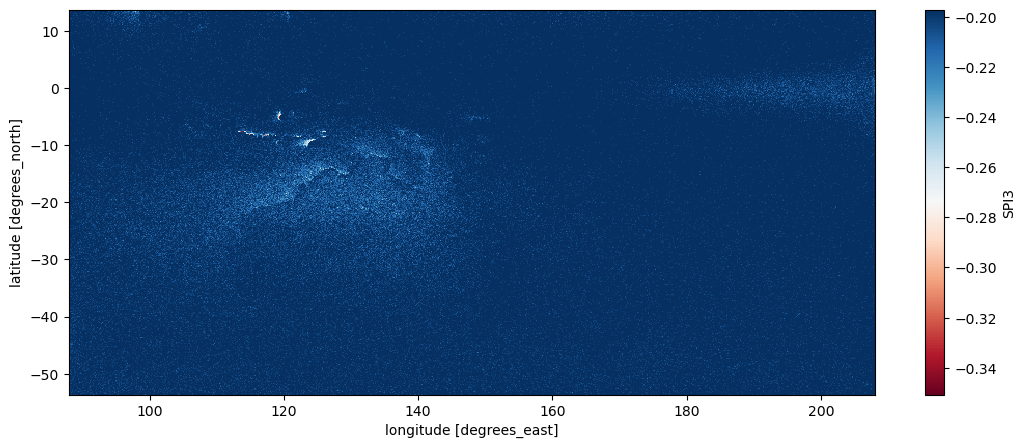

In [23]:
spi_mean = spi_ds["SPI3"].sel(time=slice('1991','2020')).mean('time')
spi_mean.plot(figsize=(13,5),cmap='RdBu')

In [ ]:
spi_mean = spi_ds["SPI3"].sel(time=slice('2011','2030')).mean('time')
spi_mean.plot(figsize=(13,5),cmap='RdBu')

In [ ]:
spi_mean = spi_ds["SPI3"].sel(time=slice('2039','2058')).mean('time')
spi_mean.plot(figsize=(13,5),cmap='RdBu')

In [ ]:
spi_ds["SPI3"].isel(time=slice(1099,1111)).plot(col='time', col_wrap=4,cmap='RdBu')

In [ ]:
# corresponding rainfall (running sum over nmonths)
pr_3 = da.rolling(time=nmonths, center=False).sum(skipna=False).dropna(dim='time',how='any')
pr_3.isel(time=slice(1099,1111)).plot(col='time', col_wrap=4,cmap="viridis_r")

In [ ]:
spi_ds = xr.open_dataset(odir+'SPI3_agcd_v101_1911-2020.nc')
spi_ts = spi_ds["SPI3"].sel(lat=36,lon=143,method='nearest')#mean(['lat','lon'])
spi_ts.plot(figsize=(13,5))

In [ ]:
spi_mean = spi_ds["SPI3"].sel(time=slice('2005','2010')).mean('time')
spi_mean.plot(figsize=(13,5),cmap='RdBu')

In [ ]:
spi_mean = spi_ds["SPI3"].sel(time=slice('1950','1970')).mean('time')
spi_mean.plot(figsize=(13,5),cmap='RdBu')

In [ ]:
#< For python executable script

# ################################################################################


# if __name__ == '__main__':
#     import dask.distributed
#     import sys

#     ## Get the number of CPUS in the job and start a dask.distributed cluster
#     mem          = 190
#     cores        = int(os.environ.get('PBS_NCPUS','4'))
#     memory_limit = '{}gb'.format(int(max(mem/cores, 4)))
#     # client       = dask.distributed.Client(n_workers=cores, threads_per_worker=1, memory_limit=memory_limit, local_dir=tempfile.mkdtemp())
#     client       = climtas.nci.GadiClient()#n_workers=cores, threads_per_worker=1, memory_limit=memory_limit, local_dir=tempfile.mkdtemp())


#     #< Print client summary
#     print('### Client summary')
#     print(client,memory_limit)
#     print('\n\n')

#     #< Call the main function
#     main(**dict(arg.split('=') for arg in sys.argv[1:]))

#     #< Close the client
#     client.shutdown()